## Download repo


In [0]:
import os
import shutil
import zipfile
import urllib.request

In [0]:
REPO_ZIP_FILE = 'LinearizedNNs-master.zip'
urllib.request.urlretrieve('https://github.com/maxkvant/LinearizedNNs/archive/master.zip', REPO_ZIP_FILE)

REPO_PATH = "LinearizedNNs-master"
if os.path.exists(REPO_PATH):
    shutil.rmtree(REPO_PATH)
    
with zipfile.ZipFile(REPO_ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall('.')
    
assert os.path.exists(REPO_PATH)

## Imports

In [0]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [4]:
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from xgboost import XGBClassifier

from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import warm_up_batch_norm
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def to_zca(train, test, min_divisor=1e-8, zca_bias=0.0001, return_weights=True):
    origTrainShape = train.shape
    origTestShape = test.shape

    train = np.ascontiguousarray(train, dtype=np.float32).reshape(train.shape[0], -1).astype('float64')
    test = np.ascontiguousarray(test, dtype=np.float32).reshape(test.shape[0], -1).astype('float64')


    nTrain = train.shape[0]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]
    test = test - np.mean(test, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)
    test_norms = np.linalg.norm(test, axis=1)

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]
    test = test/test_norms[:,np.newaxis]

    data_means = np.mean(train, axis=1)


    trainCovMat = 1.0/nTrain * train.T.dot(train)

    (E,V) = np.linalg.eig(trainCovMat)

    E += zca_bias
    sqrt_zca_eigs = np.sqrt(E)
    inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
    global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T)

    train = (train).dot(global_ZCA)
    test = (test).dot(global_ZCA)
    if return_weights:
        return (train.reshape(origTrainShape).astype('float64'), test.reshape(origTestShape).astype('float64')), global_ZCA
    else:
        return (train.reshape(origTrainShape).astype('float64'), test.reshape(origTestShape).astype('float64'))

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def Conv(in_filters, out_filters):
    conv = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1, bias=False)
    conv.weight.data *= np.sqrt(3)
    return conv  

def BatchNorm(num_filters):
    return nn.BatchNorm2d(num_filters)   

class Myrtle10(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256):
        super(Myrtle10, self).__init__()

        self.layers = nn.Sequential(
            Conv(input_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),

            Conv(num_filters, num_filters),   BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters),   BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        self.classifier.weight.data *= np.sqrt(3)
        
        self.to_readout = nn.Linear(num_filters, num_filters, bias=False)
        self.to_readout.weight.data *= np.sqrt(3)

    def readout(self, x):
        x = self.layers(x)
        return x * np.sqrt(2)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

## Cifar10

In [0]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None, zca=None):
        assert len(data) == len(targets)
        self.data = data
        self.targets = targets
        self.transform = transform
        self.zca       = zca

    def __getitem__(self, idx):
        img, y = self.data[idx], self.targets[idx]
        img = Image.fromarray(img, "RGB")
        
        if self.transform:
            img = self.transform(img)

        if self.zca:
          original_shape = img.shape
          img_zca = np.dot(img.astype(np.float64).reshape(-1), zca)
        return .reshape(original_shape), y

    def __len__(self):
        return len(self.data)

In [0]:
class DatasetZCA(torch.utils.data.Dataset):
  def __init__(self, dataset, zca):
    self.dataset = dataset
    self.zca = torch.tensor(zca)
  
  def __getitem__(self, idx):
    x, y = self.dataset(x)
    x_zca = x.view(-1).dot(self.zca) 
    return x.view(-1).dot(self.zca), y

  def 

In [0]:
def cifar_zca():
  trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
  testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

  X_train = np.asarray(trainset.data).astype(np.float64)
  y_train = np.asarray(trainset.targets)
  X_test  = np.asarray(testset.data).astype(np.float64)
  y_test  = np.asarray(testset.targets)

  (X_train, X_test), global_ZCA = to_zca(X_train, X_test)
  return X_train, y_train, X_test, y_test

In [61]:
%%time

X_train, y_train, X_test, y_test = cifar_zca()

Files already downloaded and verified
Files already downloaded and verified


ValueError: ignored

In [37]:
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Lambda(lambda x: np.asarray(x)),
    transforms.ToTensor(),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transfrom_test)

cifar_train = CustomImageDataset(X_train, y_train, transform_train)
cifar_test  = CustomImageDataset(X_train, y_train, transform_test)

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=512, shuffle=True, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=512, shuffle=True, pin_memory=True)

device

device(type='cuda', index=0)

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


0.13033949

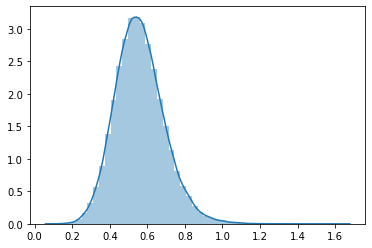

In [38]:
model = Myrtle10().to(device)

for batch_id, (X, y) in enumerate(train_loader):
  if batch_id > 20:
    break
  X, y = X.to(device), y.to(device)
  model.readout(X)

_, (X, y) = next(enumerate(train_loader))
X, y = X.to(device), y.to(device)


output = model.readout(X).detach().cpu().numpy()
sns.distplot(output.reshape(-1))

np.std(output.reshape(-1))

In [41]:
X_train.shape

(50000, 32, 32, 3)

In [60]:
np.quantile(X_train.reshape(-1))

TypeError: ignored

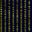

In [58]:
Image.fromarray((np.floor(X_train[3] * 100. + 120.)).astype(np.int32), "RGB")

In [55]:
np.max(X_train[0])

2.166186015763635

epoch 0/20, 0s since start


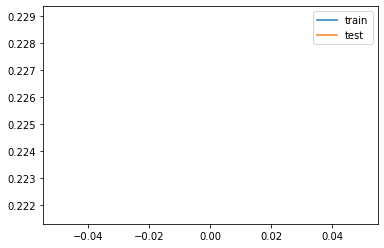

epoch 1/20, 187s since start


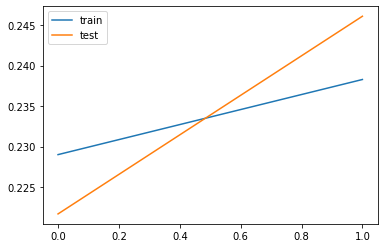

epoch 2/20, 373s since start


KeyboardInterrupt: ignored

In [40]:
model = Myrtle10(num_filters=32).to(device)

learning_rate = 0.05

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

In [0]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

In [0]:
"""
TODO experiments:
1. ZCA
2. random features with/without batchnorm
"""